# Compute Page-Wise N-GRAM Similarity

This notebook computes n-gram similarity, using Locality-Sensitive Hashing fingerprints. __Important:__
comparison is done based on __pages__, not texts as a whole!

In [1]:
import glob
import re

INPUT_FOLDER = '../../../travelogues-corpus/16th_century/books'

def read_file(f):
  with open(f, 'r') as file:
    return file.read()

filenames = [f for f in glob.glob(INPUT_FOLDER + '**/*.txt')]
texts = [ read_file(f) for f in filenames ]

f'Loaded {len(texts)} documents'

'Loaded 66 documents'

In [2]:
import re

blank_line_regex = r"(?:\r?\n){2,}"
pages_per_text = list(map(lambda l: re.split(blank_line_regex, l.strip()), texts))

cleaned_pages_per_text = []
for pages in pages_per_text:
  # ASCII characters only
  cleaned = [ re.sub('[^A-Za-z0-9 ]+', '', page) for page in pages ]

  # Replace multiple spaces by one
  cleand = [ re.sub('\\s+', ' ', page) for page in cleaned ]

  # Remove empty pages
  cleaned = [ p.strip() for p in cleaned if len(p.strip()) > 0 ]

  cleaned_pages_per_text.append(cleaned)

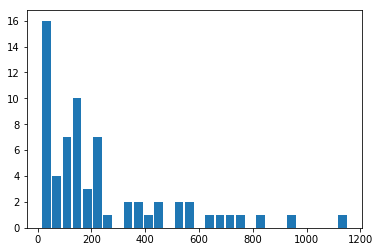

In [4]:
import matplotlib.pyplot as plt

# Keep a record of pages per text
page_lengths = [ len(pages) for pages in cleaned_pages_per_text ]

plt.hist(page_lengths, bins=30, rwidth=0.85)
plt.show()

In [5]:
from datasketch import MinHashLSH
from util.text import Text
import pickle

# 'Text' minhash helper objects
texts = []

for text_idx, text in enumerate(cleaned_pages_per_text):
  for page_idx, page in enumerate(text):
    texts.append(Text(text_idx, page_idx, page))

lsh = MinHashLSH(threshold=0.8, num_perm=128)

for t in texts:
  lsh.insert(t.id(), t.minhash())

# Save for later (computation takes a lot of time...)
# pickle.dump(lsh, open('./lsh.bin', 'wb'))

f'Built LSH index for {len(texts)} pages'

'Built LSH index for 15906 pages'

In [6]:
neighbour_pairs = []

for t in texts:
  result = lsh.query(t.minhash())

  # Result will always contain the message itself - remove
  result = [r for r in result if r != t.id()]

  for neighbour in result:
    neighbour_pairs.append([ t.id(), neighbour ])

Now aggregate the page-level results to a simple book-level "score", where the score is simply
the number of identified pairs above the LSH threshold. 

In [10]:
import pandas as pd 

def to_barcode(filename):
  return filename[filename.rindex('/') + 1: -4]

as_dict = {}

for pair in neighbour_pairs:
  from_book = int(pair[0].split(',')[0])
  to_book = int(pair[1].split(',')[0])

  if (from_book != to_book):
    # Key is always from lower idx to higher idx
    key = f'{from_book},{to_book}' if from_book < to_book else f'{to_book},{from_book}'

    if key in as_dict:
      as_dict[key] = as_dict[key] + 1
    else:
      as_dict[key] = 1

as_list = []
for key in as_dict.keys():
  indexes = key.split(',')

  idx_a = int(indexes[0])
  idx_b = int(indexes[1])

  file_a = to_barcode(filenames[idx_a])
  file_b = to_barcode(filenames[idx_b])

  url_a = f'http://data.onb.ac.at/ABO/+{file_a}'
  url_b = f'http://data.onb.ac.at/ABO/+{file_b}'

  score = as_dict[key]

  normalized = score / (page_lengths[idx_a] + page_lengths[idx_b])

  as_list.append([ file_a, file_b, score, normalized, url_a, url_b ])

as_list = sorted(as_list, key = lambda x: -x[2])

# This data frame now contains book indices and score
df = pd.DataFrame(as_list, columns=['a', 'b', 'num_pairs', 'normalized', 'url_a', 'url_b'])
df

,a,b,num_pairs,normalized,url_a,url_b
0,Z18514390X,Z176246604,8680,5.733157,http://data.onb.ac.at/ABO/+Z18514390X,http://data.onb.ac.at/ABO/+Z176246604
1,Z185912505,Z176246604,7280,4.013230,http://data.onb.ac.at/ABO/+Z185912505,http://data.onb.ac.at/ABO/+Z176246604
2,Z184929303,Z176246604,5880,4.326711,http://data.onb.ac.at/ABO/+Z184929303,http://data.onb.ac.at/ABO/+Z176246604
3,Z253367704,Z176246604,5040,2.722853,http://data.onb.ac.at/ABO/+Z253367704,http://data.onb.ac.at/ABO/+Z176246604
4,Z180628606,Z176246604,4760,2.631288,http://data.onb.ac.at/ABO/+Z180628606,http://data.onb.ac.at/ABO/+Z176246604
5,Z176246604,Z185143704,4760,3.489736,http://data.onb.ac.at/ABO/+Z176246604,http://data.onb.ac.at/ABO/+Z185143704
6,Z163300909,Z176246604,3920,2.492053,http://data.onb.ac.at/ABO/+Z163300909,http://data.onb.ac.at/ABO/+Z176246604
7,Z160260500,Z176246604,3920,2.637954,http://data.onb.ac.at/ABO/+Z160260500,http://data.onb.ac.at/ABO/+Z176246604
8,Z168096506,Z176246604,3360,1.777778,http://data.onb.ac.at/ABO/+Z168096506,http://data.onb.ac.at/ABO/+Z176246604
9,Z176246604,Z185158008,3360,2.559025,http://data.onb.ac.at/ABO/+Z176246604,http://data.onb.ac.at/ABO/+Z185158008


In [11]:
df.to_csv('../../results/similarity_lsh_pagewise.csv', index=False)